In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import joblib

# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)



In [5]:
# Display all column names in the dataset
print(data.columns)

Index(['SpotPriceDKK', 'from', 'to', 'temp_Aabenraa', 'temp_Aalborg',
       'temp_Aarhus', 'temp_Assens', 'temp_Billund', 'temp_Brønderslev',
       'temp_Esbjerg',
       ...
       'wind_speed_Thisted', 'wind_speed_Tønder', 'wind_speed_Varde',
       'wind_speed_Vejen', 'wind_speed_Vejle', 'wind_speed_Vesthimmerlands',
       'wind_speed_Viborg', 'wind_speed_Ærø', 'natural_gas', 'crude_oil'],
      dtype='object', length=473)


In [30]:
# Ensure the 'from' column is in datetime format and set it as index
data['from'] = pd.to_datetime(data['from'])
data = data.set_index('from')
data.index = pd.DatetimeIndex(data.index.values, freq=pd.infer_freq(data.index))

# Training data: from August 1, 2023, to August 1, 2024
train_start_date = '2023-08-01'
train_end_date = '2024-08-01'
train_data = data[(data.index >= train_start_date) & (data.index <= train_end_date)]
spot_price_train = train_data['SpotPriceDKK']

In [31]:
# Fit the SARIMA model (ARIMA(2,0,0)(2,0,1)[24] with intercept)
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output
sarima_model = SARIMAX(spot_price_train, order=(2, 0, 0), seasonal_order=(2, 0, 1, 24), trend='c')
sarima_results = sarima_model.fit(disp=False)

RMSE: 317.0535119042118


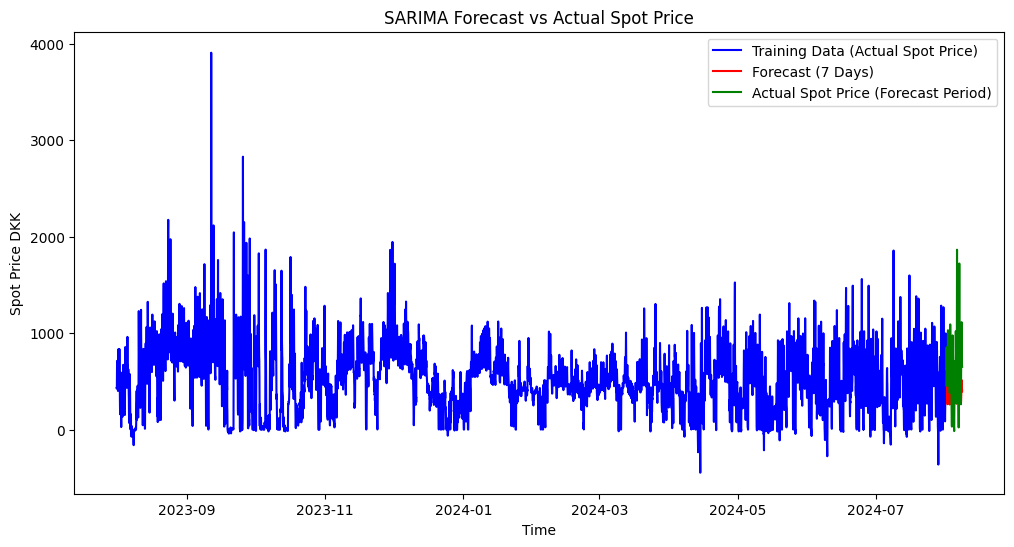

In [39]:
#Calculate MAE
mae = np.mean(np.abs(actual_spot_price - forecast))
print(f"MAE: {mae}")

MAE: 154.05084040845074


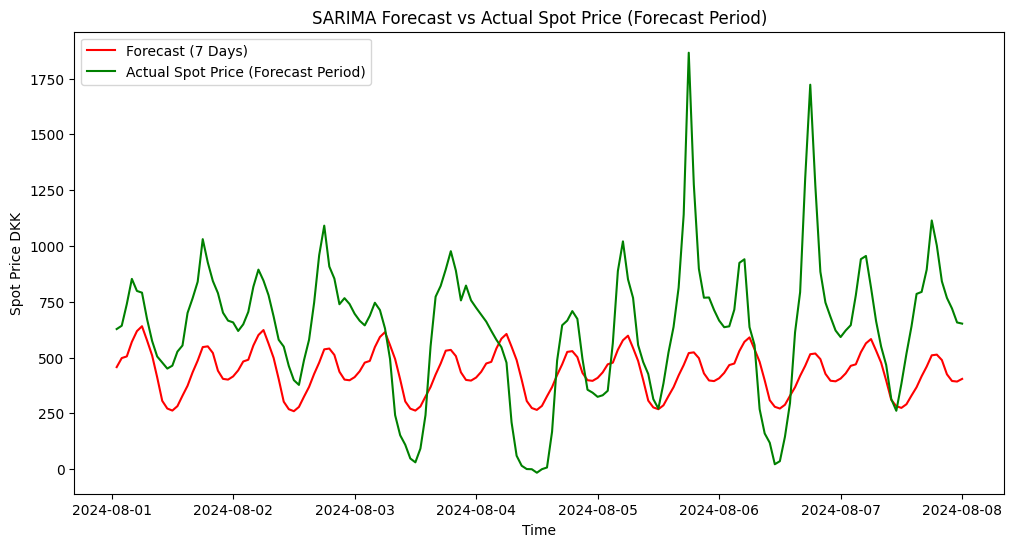

In [33]:
# Plot the forecast and actual values for the forecast period
plt.figure(figsize=(12, 6))
plt.plot(forecast, label='Forecast (7 Days)', color='red')
if not actual_values.empty:
    plt.plot(actual_spot_price, label='Actual Spot Price (Forecast Period)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Forecast Period)')
plt.legend()
plt.show()

In [51]:
# Continue from the existing SARIMA code

# Forecasting parameters
forecast_steps = 24  # Forecast in 24-hour chunks
history = spot_price_train.copy()  # Start with training data
forecast_values = []

# Generate rolling forecasts for the next 7 days, using actual values lagged by 24 hours
sarima_model = SARIMAX(history, order=(2, 0, 0), seasonal_order=(2, 0, 1, 24), trend='c')
sarima_results = sarima_model.fit(disp=False)

# Start forecasting from after the training end date (August 1, 2024)
forecast_start = pd.Timestamp('2024-08-01') + pd.Timedelta(hours=1)

for i in range(7):  # Forecast for 7 days, one day at a time (24-hour steps)
    # Define the start and end times for the forecast chunk
    forecast_end = forecast_start + pd.Timedelta(hours=forecast_steps - 1)
    forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='H')
    
    # Generate forecast for the next 24 hours
    forecast = sarima_results.get_forecast(steps=forecast_steps).predicted_mean
    forecast.index = forecast_index

    # Store the forecasted values
    forecast_values.append(forecast)
    
    # Update history with actual values from the dataset for the next 24 hours, lagged by 24 hours
    if forecast_end in data.index:
        actual_values = data[forecast_start:forecast_end]['SpotPriceDKK']
        # Use actual values for the next iteration, starting after the training end date
        history = pd.concat([history, actual_values])
    else:
        # If actual values are not available, use the forecast
        history = pd.concat([history, forecast])
    
    # Update the forecast start for the next iteration
    forecast_start = forecast_end + pd.Timedelta(hours=1)

# Combine all forecasted values into a single series
forecast_values = pd.concat(forecast_values)

# Extract actual values for the entire forecast period
actual_start_date = forecast_values.index[0]
actual_end_date = forecast_values.index[-1]
actual_values = data[(data.index >= actual_start_date) & (data.index <= actual_end_date)]



In [56]:
# Calculate RMSE if actual values are available
if not actual_values.empty:
    actual_spot_price = actual_values['SpotPriceDKK']
    rmse = np.sqrt(mean_squared_error(actual_spot_price, forecast_values))
    print(f"RMSE: {rmse}")

# Calculate MAE
mae = np.mean(np.abs(actual_spot_price - forecast_values))
print(f"MAE: {mae}")


RMSE: 307.1938890041035
MAE: 252.17380259653544


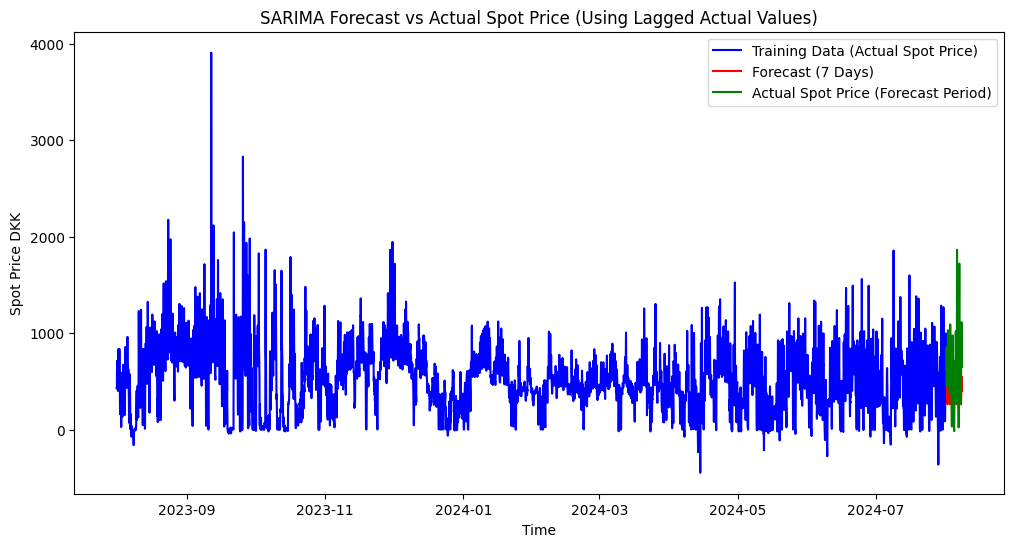

In [53]:
# Plot the training data, forecast, and actual values
plt.figure(figsize=(12, 6))
plt.plot(spot_price_train, label='Training Data (Actual Spot Price)', color='blue')
plt.plot(forecast_values, label='Forecast (7 Days)', color='red')
if not actual_values.empty:
    plt.plot(actual_spot_price, label='Actual Spot Price (Forecast Period)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Using Lagged Actual Values)')
plt.legend()
plt.show()

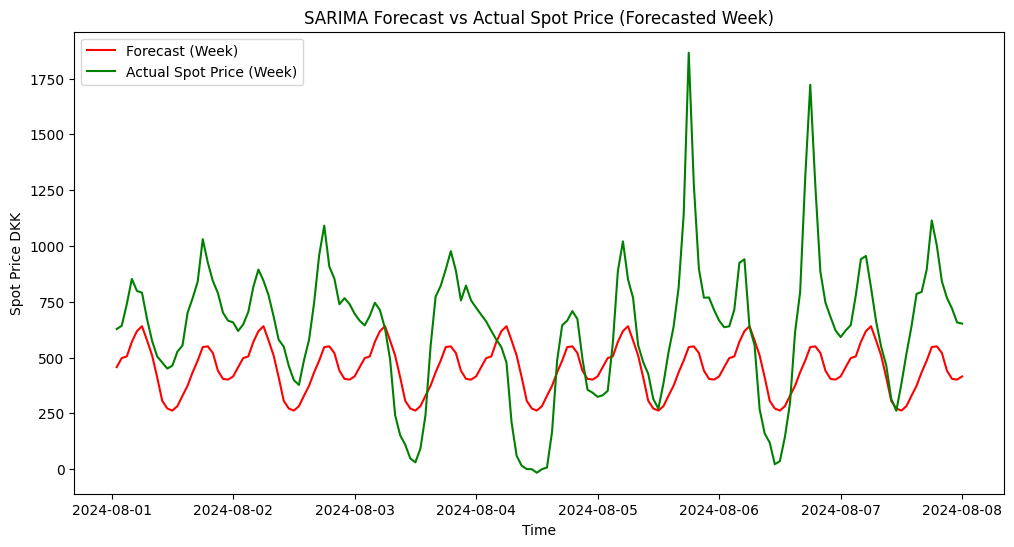

In [57]:
# Ensure the indices are sorted
forecast_values = forecast_values.sort_index()
actual_spot_price = actual_spot_price.sort_index()

# Extract the forecasted week and corresponding actual data
forecast_week = forecast_values['2024-08-01 01:00:00':'2024-08-08 00:00:00']
actual_week = actual_spot_price['2024-08-01 01:00:00':'2024-08-08 00:00:00']

# Plot the forecasted week and actual data
plt.figure(figsize=(12, 6))
plt.plot(forecast_week, label='Forecast (Week)', color='red')
plt.plot(actual_week, label='Actual Spot Price (Week)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Forecasted Week)')
plt.legend()
plt.show()